In [7]:
import cv2
from PIL import Image, ImageDraw
import numpy as np
import random
import os
import math
from tqdm.contrib import itertools
import utils.detect_line as detect_line

from yacs.config import CfgNode as CN

In [2]:
WEITAO = 2   #

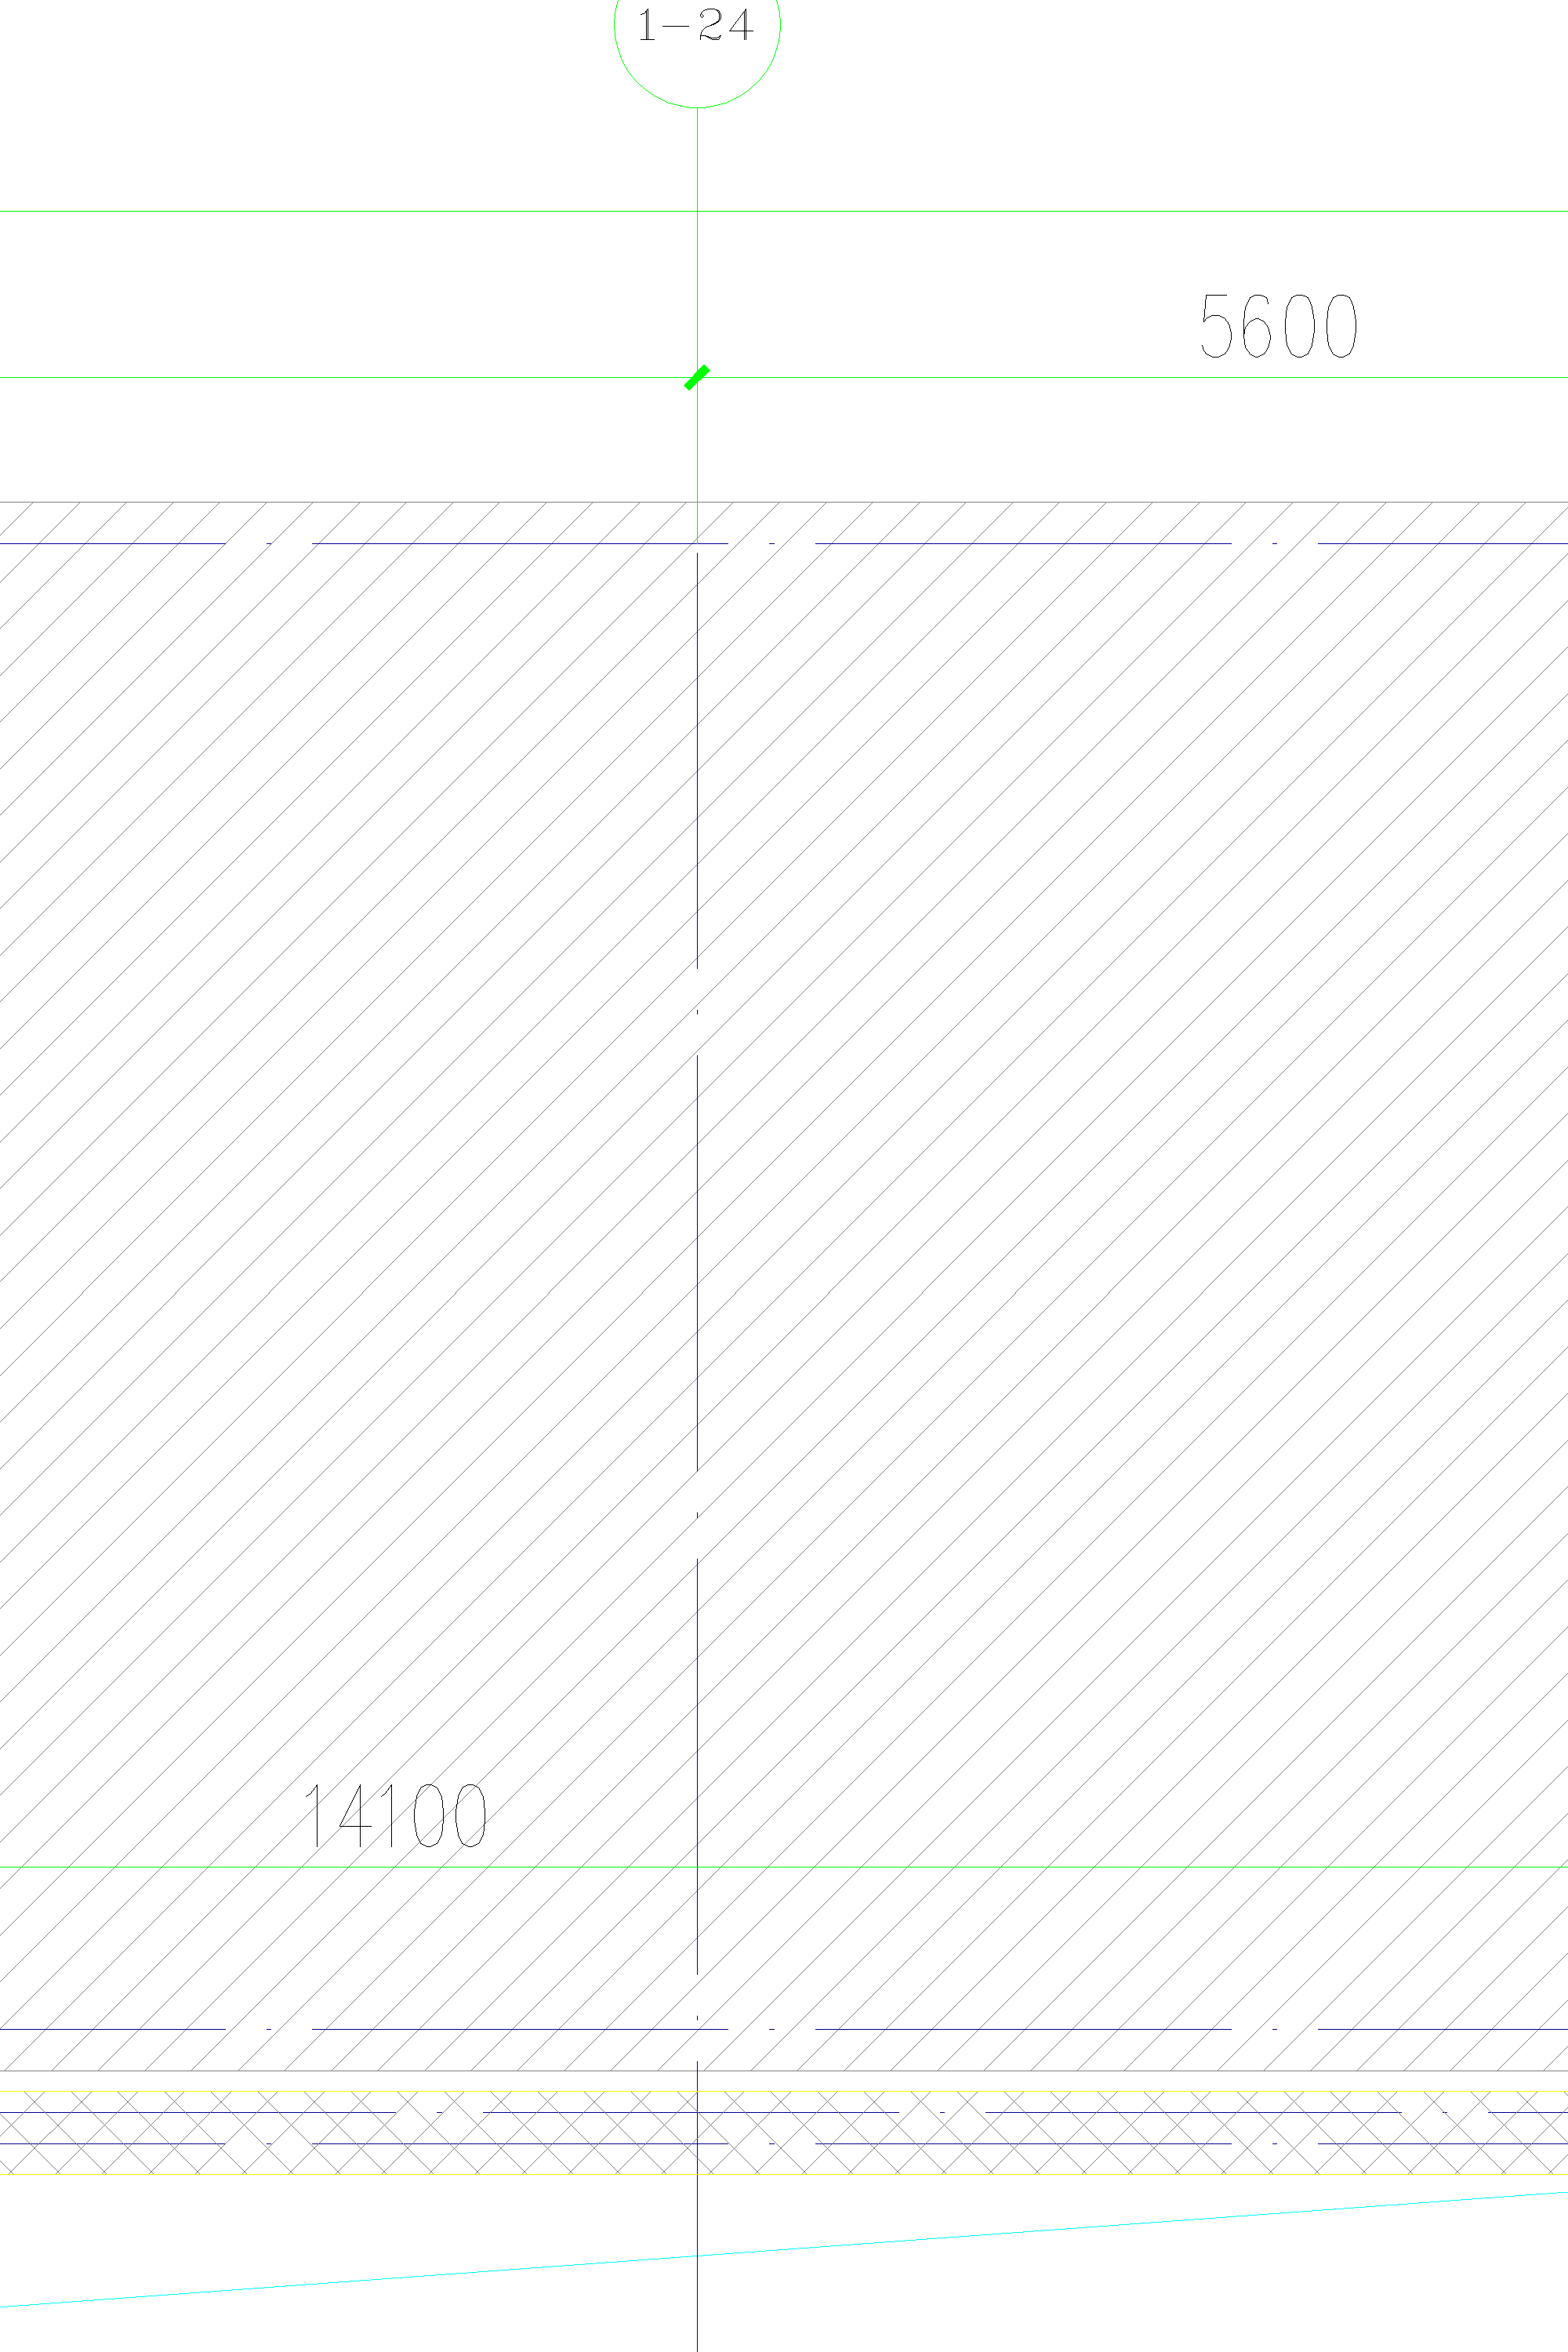

In [6]:
ori_img = cv2.imread('../static/img/1.png')
ori_img = ori_img[5000:8000, 5000:7000, :]
Image.fromarray(ori_img)

In [9]:
lines, _ = detect_line.detect_lines(ori_img)

  0%|          | 0/2 [00:00<?, ?it/s]

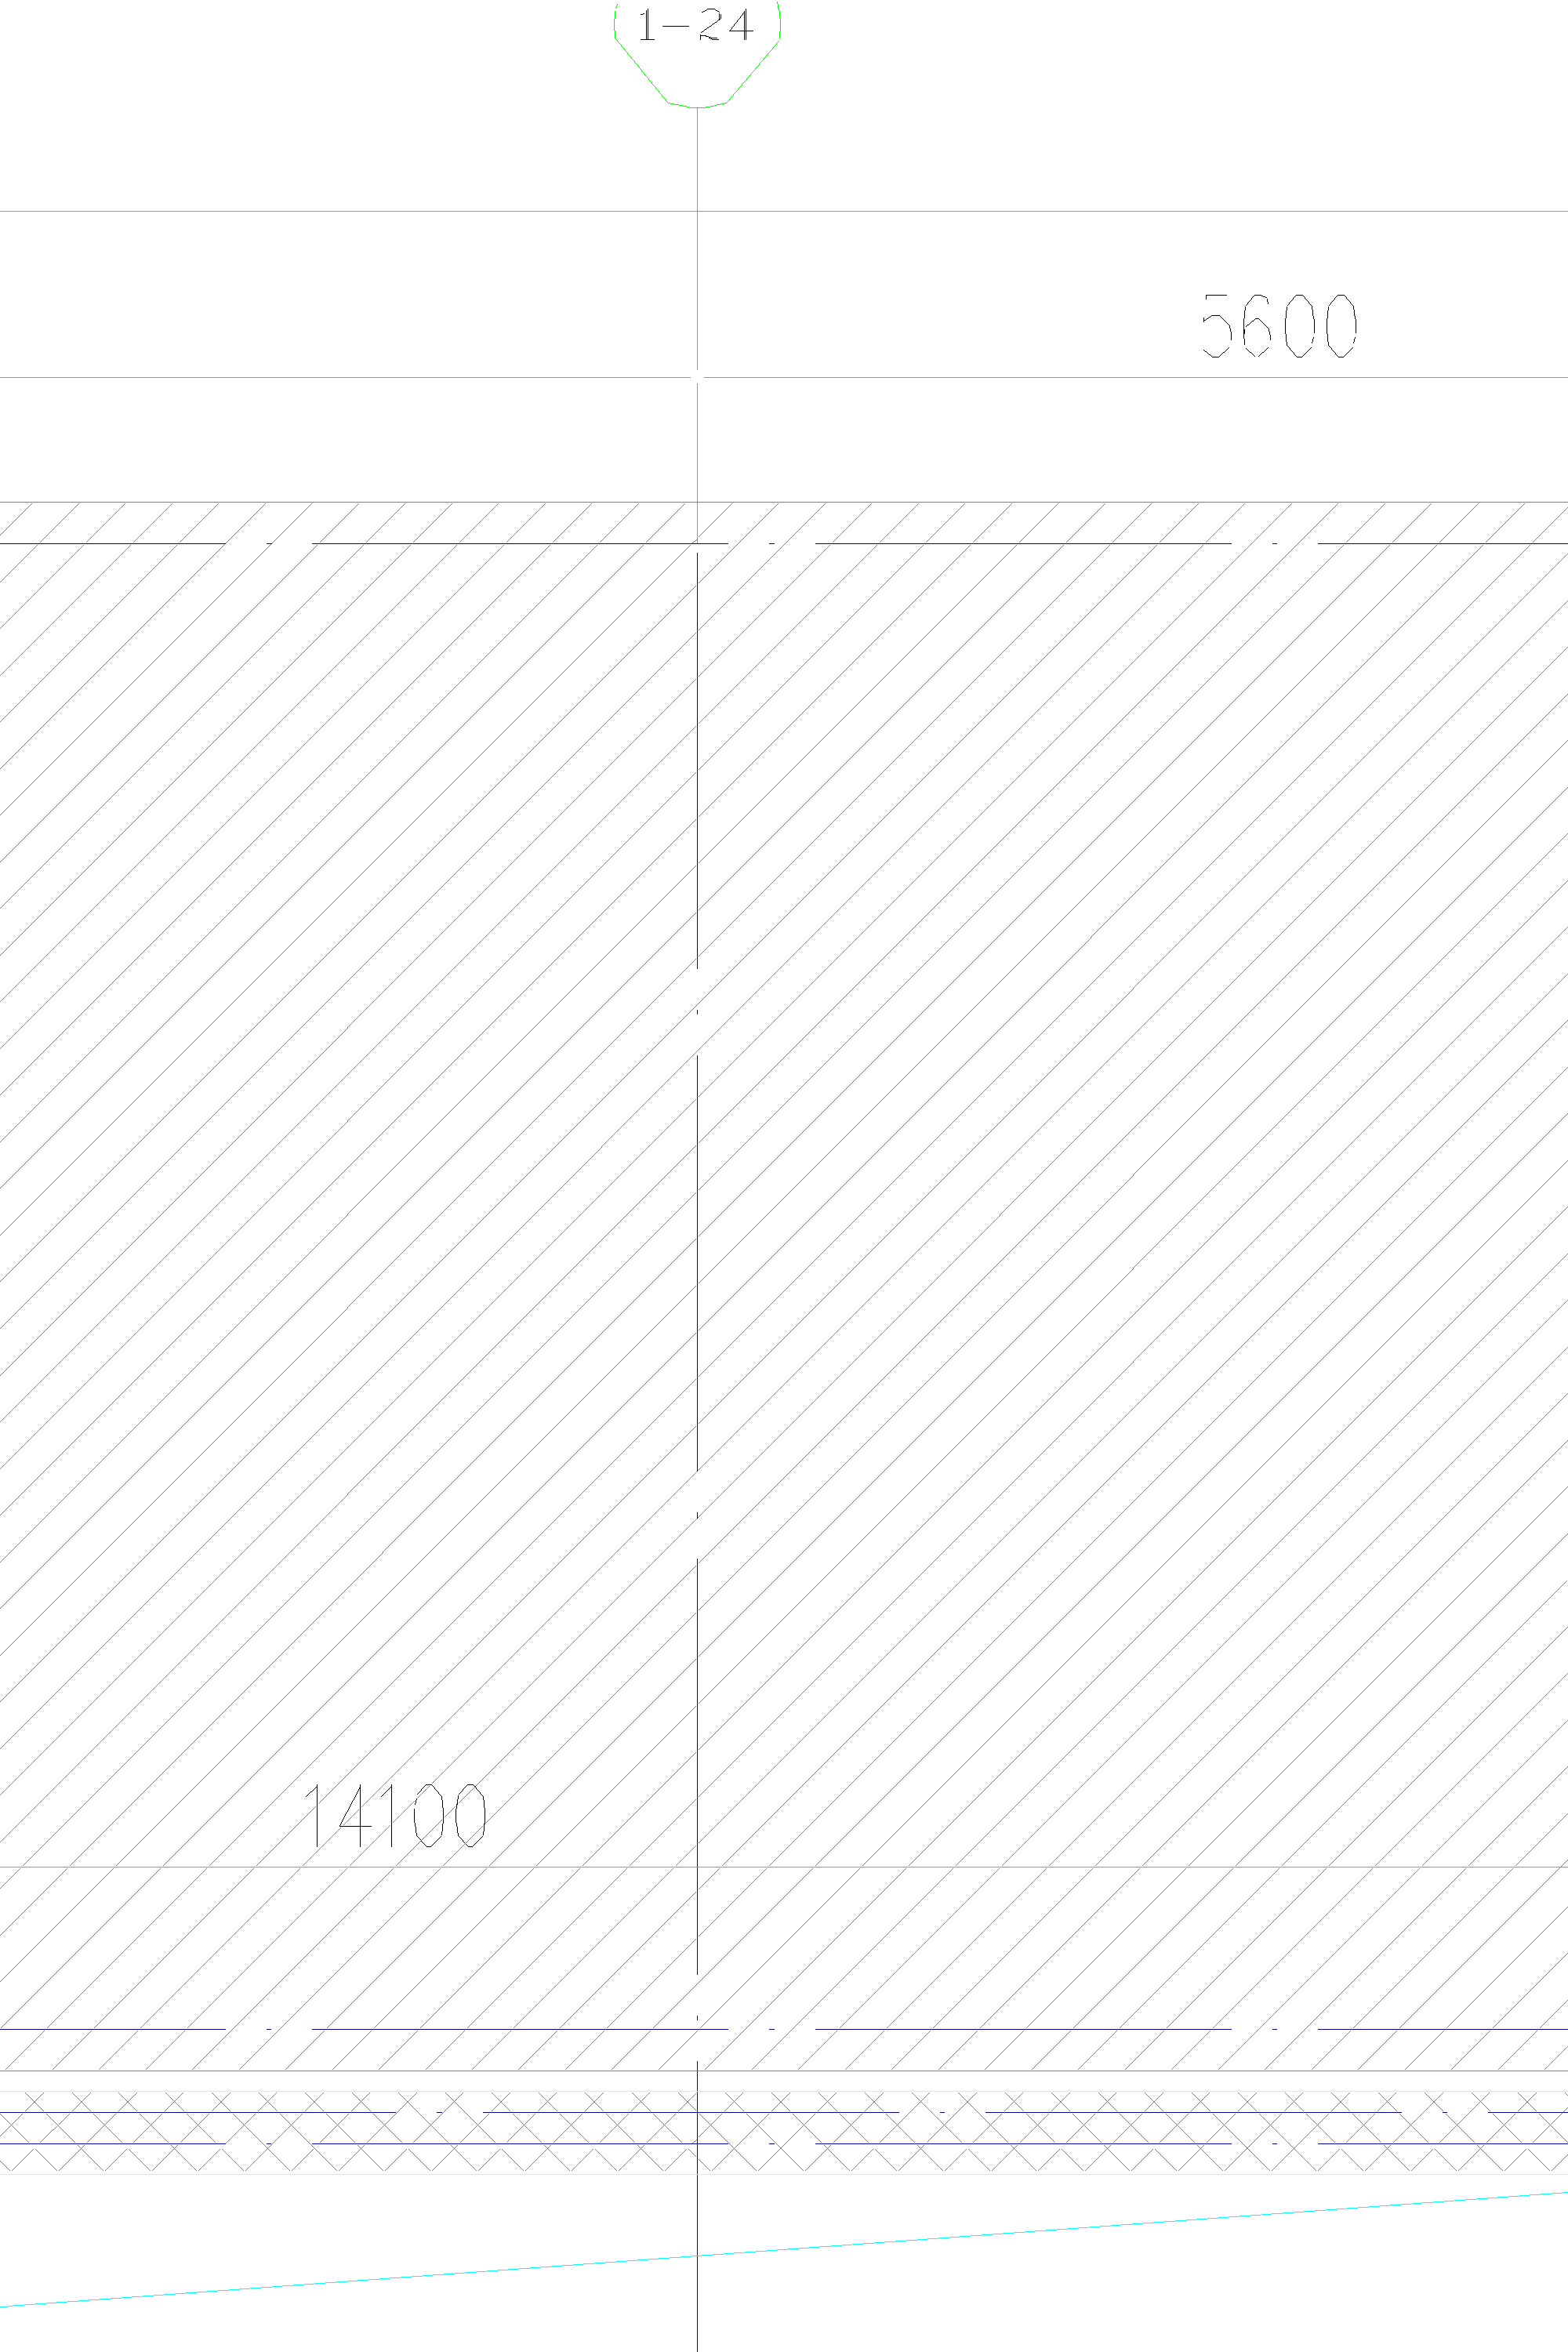

In [10]:
white = np.ones_like(ori_img) * 255
for line in lines:
    cv2.line(white, line[0], line[1], line[2], 1)
Image.fromarray(white)

In [11]:
class ChainForwardStar:
    # 链式前向星
    def __init__(self, num_node, num_edge):
        self.num_node = num_node
        self.h = np.ones(num_node, dtype=np.int32) * -1
        self.e = np.zeros(num_edge, dtype=np.int32)
        self.ne = np.zeros(num_edge, dtype=np.int32)
        self.idx = 0

    def add_edge(self, u, v):
        self.e[self.idx] = v
        self.ne[self.idx] = self.h[u]
        self.h[u] = self.idx
        self.idx += 1

    def get_neighbors(self, u):
        neighbors = []
        p = self.h[u]
        while p != -1:
            neighbors.append(self.e[p])
            p = self.ne[p]
        return neighbors

class UnionFind:
    # 并查集
    def __init__(self, size):
        # 初始化每个元素的父节点为自己
        self.parent = list(range(size))
        # 可选：初始化每个集合的元素数量，如果不需要统计集合大小可以省略
        self.rank = [1] * size

    def find(self, x):
        """查找x的根节点，使用路径压缩"""
        if self.parent[x] != x:
            # 路径压缩：将x的父节点设为其根节点的父节点
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        """合并x和y所在的集合"""
        rootX = self.find(x)
        rootY = self.find(y)
        if rootX != rootY:
            # 如果x和y不在同一个集合中，则将较小的集合合并到较大的集合上
            if self.rank[rootX] > self.rank[rootY]:
                self.parent[rootY] = rootX
                self.rank[rootX] += self.rank[rootY]
            else:
                self.parent[rootX] = rootY
                self.rank[rootY] += self.rank[rootX]

    def connected(self, x, y):
        """判断x和y是否在同一集合中"""
        return self.find(x) == self.find(y)

    def get_sets(self):
        """返回并查集中所有连通集合的列表"""
        # 创建一个字典，键是根节点，值是属于该根节点的集合元素列表
        sets_dict = {}
        for i in range(len(self.parent)):
            root = self.find(i)
            if root not in sets_dict:
                sets_dict[root] = []
            sets_dict[root].append(i)

        # 将字典转换为列表
        return list(sets_dict.values())


In [12]:
num_lines = len(lines)
cfs = ChainForwardStar(num_lines, num_lines * 10)

# 反向处理，减时间复杂度
dic = {}
for i, line in enumerate(lines):
    dic[line[0]] = i
    dic[line[1]] = i

# 链式前向星存图
for i, line in enumerate(lines):
    for pt in [line[0], line[1]]:
        # for r in range(1, eps + 1):
        r = 5
        for dx in range(pt[0] - r, pt[0] + r + 1):
            for dy in range(pt[1] - r, pt[1] + r + 1):
                if (dx, dy) in dic and i != dic[(dx, dy)]:
                    cfs.add_edge(i, dic[(dx, dy)])

uf = UnionFind(num_lines)
for i in range(num_lines):
    for j in cfs.get_neighbors(i):
        if uf.connected(i, j):
            continue
        uf.union(i, j)

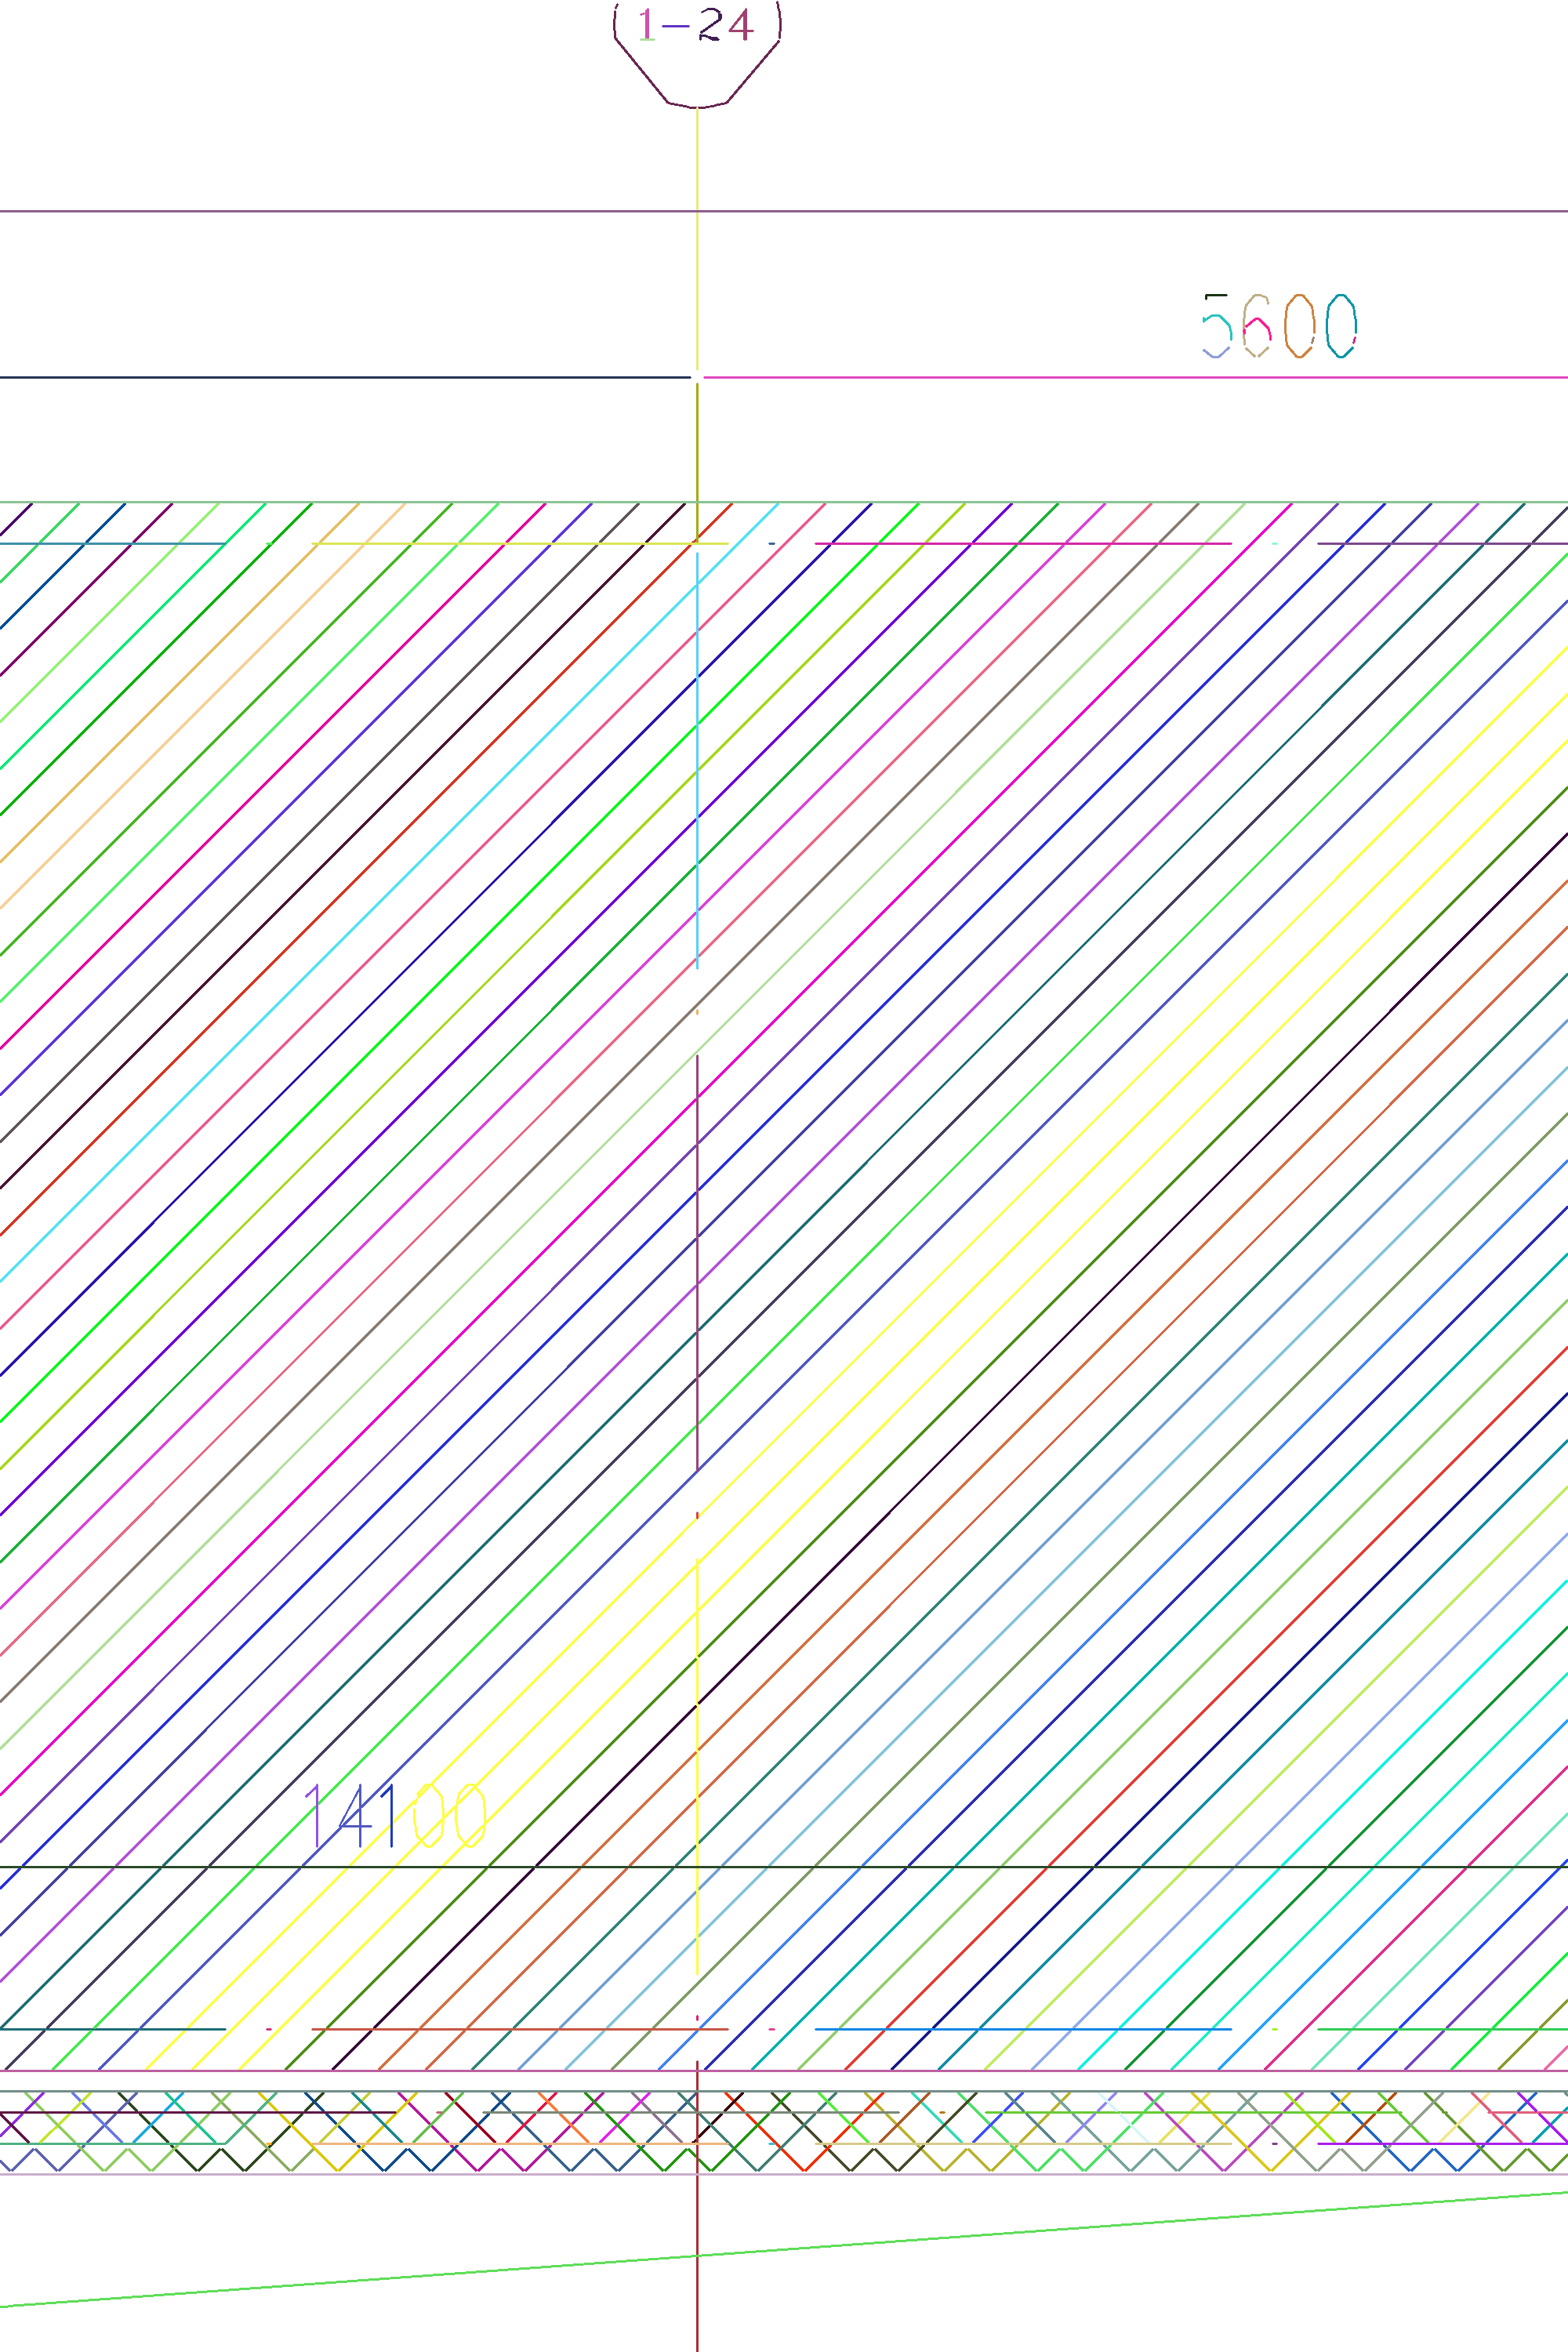

In [13]:
sets = uf.get_sets()
white = np.ones_like(ori_img) * 255
for set_ in sets:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    for idx in set_:
        line = lines[idx]
        cv2.line(white, line[0], line[1], color, 2)
Image.fromarray(white)

In [14]:
lines  # [[(x1, y1), (x2, y2), (r, g, b)], ... , ]

[[(0, 2230), (1534, 695), (128, 128, 128)],
 [(0, 1158), (463, 695), (128, 128, 128)],
 [(0, 1992), (887, 1104), (128, 128, 128)],
 [(0, 920), (225, 695), (128, 128, 128)],
 [(981, 2379), (1999, 1361), (128, 128, 128)],
 [(0, 2289), (887, 1402), (128, 128, 128)],
 [(1516, 2379), (1999, 1896), (128, 128, 128)],
 [(891, 2350), (1999, 1242), (128, 128, 128)],
 [(0, 2170), (1475, 695), (128, 128, 128)],
 [(0, 1932), (887, 1045), (128, 128, 128)],
 [(921, 2379), (1999, 1301), (128, 128, 128)],
 [(891, 2291), (1999, 1182), (128, 128, 128)],
 [(891, 1219), (1415, 695), (128, 128, 128)],
 [(891, 2053), (1999, 944), (128, 128, 128)],
 [(891, 981), (1177, 695), (128, 128, 128)],
 [(1836, 691), (1885, 642), (128, 128, 128)],
 [(29, 2379), (887, 1521), (128, 128, 128)],
 [(1159, 2379), (1999, 1539), (128, 128, 128)],
 [(891, 2231), (1999, 1123), (128, 128, 128)],
 [(0, 1218), (523, 695), (128, 128, 128)],
 [(0, 980), (338, 642), (128, 128, 128)],
 [(208, 2379), (887, 1700), (128, 128, 128)],
 [(0,

In [15]:
for idx, set_ in enumerate(sets):
    if len(set_) != 1:
        print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
49
50
51
52
53
55
56
63
64
65
66
67
68
69
70
72
87
88
89
90
92
93
94
95
96
97
98
99
100
102
103
104
105
106
107
108
109
110
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
129
130
132
134
135
136
137
138
140
141
142
143
144
145
146
147
148
149
160
170


In [16]:
sets[131]

[338]

In [17]:
vertex = [lines[235], lines[236]]
edges = [[0, 1]]

In [18]:
len(sets)

171